In [1]:
from pydub import AudioSegment
from pathlib import Path
import numpy as np
import IPython.display as ipd
import pandas as pd
import _pickle as pickle
import csv
import humming_data_utils as utils
import matplotlib.pyplot as plt
import torch
from sampling_utils import downsample_contour_array

In [2]:
%load_ext autoreload
%autoreload 2
import humming_data_utils as utils
selected_100, selected_900 = utils.load_meta_from_excel()
humming_db = utils.HummingDB('/home/svcapp/userdata/humming_db', '/home/svcapp/userdata/flo_data_backup/', selected_100, selected_900)

track_ids = list(set([x['track_id'] for x in humming_db.samples]))

In [3]:
def normalized_vec_to_orig(norm_contour, mean_pitch=69, std=5.5201786930065415):
    orig = np.zeros_like(norm_contour[:,0])
    orig[norm_contour[:,1]==1] = 440 * 2 ** ((norm_contour[norm_contour[:,1]==1, 0] * std + mean_pitch -69) / 12)
#     orig[norm_contour==-100] = 0
    return orig


def generate_sine_wav(melody, frame_rate=10, sr=44100):
    melody_resampled = np.repeat(melody, sr//frame_rate)
    phi = np.zeros_like(melody_resampled)
    phi[1:] = np.cumsum(2* np.pi * melody_resampled[:-1] / sr, axis=0)
    sin_wav = 0.9 * np.sin(phi)
    return sin_wav

In [2]:
torch.__version__

'1.6.0'

In [4]:
with open('humm_db_ids.dat', 'wb') as f:
    pickle.dump(track_ids, f)

In [6]:
with open('/home/svcapp/userdata/flo_melody/overlapped.dat', 'rb') as f:
    overlap_data = pickle.load(f)

In [7]:
with open('/home/svcapp/userdata/flo_melody/humm_array.dat', 'rb') as f:
    humm_array = pickle.load(f)

In [19]:
humming_pairs = [x for x in humming_db]

In [4]:
humm_array[0][0].shape

(243, 2)

In [ ]:
contour, orig_contour = humming_db[21]
plt.plot(contour[:,0])
plt.plot(orig_contour[:,0])

In [27]:
selected_sample = humming_db.samples[0]
orig_audio_path = utils.get_orig_audio_path_by_id(selected_sample['track_id'], humming_db.audio_path)
orig_melody_path = utils.audio_path_to_pitch_path(orig_audio_path)
orig_melody = utils.load_melody_txt(orig_melody_path)
humm_melody = utils.load_crepe_pitch(selected_sample['pitch_path'])
time_pos = [int(x) for x in selected_sample['time_stamp'].split('-')]
sliced_melody = orig_melody[time_pos[0]*100 :time_pos[1]*100 ]

In [34]:
def pitch_array_to_formatted(pitch_array, mean=61.702336487738215, std=5.5201786930065415):
    output = np.zeros((len(pitch_array), 2))
    output[pitch_array!=0,1] = 1
    output[:,0] = (pitch_array - mean) / std
    output[output[:,1]==0, 0]= 0
    return output

formatted= pitch_array_to_formatted(humm_melody)

In [40]:
np.log2(humm_melody)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


array([-inf, -inf, -inf, ..., -inf, -inf, -inf], dtype=float32)

In [15]:
humm_array = [(downsample_contour_array(utils.get_normalized_contour_from_sample(sample)), sample['track_id'], sample['time_stamp'] ) for sample in humming_db.samples if sample['song_group']=="100"]


In [17]:
with open('/home/svcapp/userdata/flo_melody/humm_array.dat', 'wb') as f:
    pickle.dump(humm_array, f)

In [45]:
len(humm_array)

200

In [5]:
# plt.plot(humm_melody) 
def filter_error(array, min_clip=-3.5, max_clip=2.5, ):
    error_like_index = array[:,0] > max_clip
    error_like_index_min = array[:,0] < min_clip
    error_like_index = error_like_index + error_like_index_min
    new_array = np.copy(array)
    new_array[error_like_index, :] = 0
    return new_array

# id = 10
# plt.plot(delete_zero(humm_array[id][0])[:,0])
# plt.plot(humm_array[id][0][:,0])



NameError: name 'plt' is not defined

In [5]:
from inference import load_model, load_hparams, load_checkpoint

ckpt_path = "/home/svcapp/userdata/flo_model/contour_scheduled_hidden256_lr0.0001_201210-154640/checkpoint_best.pt"
hparams = load_hparams(ckpt_path)
model = load_model(hparams)
model = load_checkpoint(ckpt_path, model)

Loading checkpoint '/home/svcapp/userdata/flo_model/contour_scheduled_hidden256_lr0.0001_201210-154640/checkpoint_best.pt'
Loaded checkpoint '/home/svcapp/userdata/flo_model/contour_scheduled_hidden256_lr0.0001_201210-154640/checkpoint_best.pt' from iteration 47001


In [6]:
model

CnnEncoder(
  (encoder): Sequential(
    (conv_0): Res_1d(
      (conv_1): Conv1d(2, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_3): Conv1d(2, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool_0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv_1): Res_1d(
      (conv_1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn_2): BatchNorm1d(128, eps=1e

In [93]:
model(torch.Tensor(formatted).unsqueeze(0).cuda())

tensor([[-0.0644, -0.1583, -0.0571, -0.0412, -0.1089, -0.0948,  0.0605, -0.0438,
          0.0725, -0.0568, -0.1770, -0.2726, -0.0890, -0.0491, -0.0726,  0.1828,
         -0.1197,  0.0846, -0.0677, -0.0421, -0.1734,  0.1280, -0.0159, -0.0555,
          0.1690, -0.4596,  0.0691, -0.0230, -0.0578,  0.0228,  0.1780,  0.2354,
         -0.1145, -0.1322, -0.0381,  0.1128,  0.0065,  0.0561,  0.1331,  0.0497,
          0.0039, -0.0504, -0.3877,  0.0074, -0.0846, -0.0591,  0.0016, -0.1881,
         -0.1251,  0.0609,  0.0774, -0.0434, -0.0432,  0.0471,  0.1133,  0.0746,
         -0.1277,  0.1143, -0.0128, -0.0863, -0.0375,  0.0346,  0.0645,  0.0662,
          0.0079, -0.0422, -0.0764,  0.1204, -0.0519, -0.0597,  0.1227,  0.0860,
          0.0139,  0.1049,  0.0142, -0.0665, -0.1466,  0.0917,  0.0090, -0.1442,
          0.0485,  0.0632, -0.2597,  0.0176,  0.0787, -0.0294,  0.2176, -0.0254,
         -0.0630,  0.1218, -0.0313,  0.0096,  0.1272, -0.0428, -0.0720,  0.2109,
         -0.1335, -0.0125,  

In [6]:
# embeddings = torch.load("/home/svcapp/userdata/flo_melody/overlapped_embedding.pt")
embeddings = torch.load("/home/svcapp/userdata/flo_model/qbh_embedding.pt")

In [12]:
with open("/home/svcapp/userdata/flo_melody/overlapped.dat", "rb") as f:
    ballade_contours = pickle.load(f)

In [9]:
total_humm_ids = set([x[1] for x in humm_array]

SyntaxError: invalid syntax (<ipython-input-9-99ca24cd2770>, line 1)

In [8]:
from validation import cal_ndcg_single
from tqdm import tqdm

def remove_duplicate(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def cal_ndcg_of_loader(model, data_samples, total_embs, total_song_ids):
    model.eval()
    valid_score = 0
    recommended_ids = []
    for j, batch in enumerate(tqdm(data_samples)):
        contours, track_ids, time_pos = batch
        contours = torch.Tensor(contours).unsqueeze(0)
        anchor = model(contours.cuda())
        anchor_norm = anchor / anchor.norm(dim=1)[:, None]
        similarity = torch.mm(anchor_norm, total_embs.transpose(0,1))
        recommends = torch.topk(similarity, k=50, dim=-1)[1]
        for i in range(recommends.shape[0]):
            recommended_ids += recommends[i].cpu().numpy().tolist()
        recommends = total_song_ids[recommends]
#         ndcg = [cal_ndcg_single(recommends[i,:], track_ids) for i in range(recommends.shape[0])]
#         print(track_ids in recommends[0])
#         ndcg = sum(ndcg) / len(ndcg)
#         valid_score += ndcg
        recommends.squeeze_()
        recommends = remove_duplicate(recommends.tolist())[:10]
        if track_ids in recommends:
            score = 1 
        else:
            score = 0
        valid_score += score

    valid_score = valid_score/(j+1)
    return valid_score #, recommended_ids

# total_embs = torch.cat((embeddings['embs'], qbh_embeddings['embs']), dim=0).cuda()
# total_song_ids = torch.LongTensor(embeddings['ids'] + qbh_embeddings['ids'])
total_embs = embeddings['embs'].cuda()
total_song_ids = torch.LongTensor(embeddings['ids'])
cal_ndcg_of_loader(model, humm_array, total_embs, total_song_ids)

100%|██████████| 500/500 [00:04<00:00, 118.93it/s]


0.006

In [9]:
model.eval()
valid_score = 0
recommended_ids = []
batch = humm_array[0]
contours, track_ids, time_pos = batch
contours = torch.Tensor(contours).unsqueeze(0)
dummy = torch.zeros(1, 299, 2)
dummy[:,28:-28,:] = contours
anchor = model(dummy.cuda())
anchor_norm = anchor / anchor.norm(dim=1)[:, None]
similarity = torch.mm(anchor_norm, total_embs.transpose(0,1))

print(anchor[0][:10])
# recommends = torch.topk(similarity, k=50, dim=-1)[1]
# for i in range(recommends.shape[0]):
#     recommended_ids += recommends[i].cpu().numpy().tolist()
# recommends = total_song_ids[recommends]
# ndcg = [cal_ndcg_single(recommends[i,:], track_ids) for i in range(recommends.shape[0])]

# ndcg = sum(ndcg) / len(ndcg)
# valid_score = valid_score/(j+1)

tensor([-0.1722, -1.6297, -0.6128, -3.1175, -0.5750, -0.0861,  0.4333, -1.6151,
        -0.3204, -1.7963], device='cuda:0', grad_fn=<SliceBackward>)


In [10]:
model.fc.weight[0,:10]


tensor([ 0.0014, -0.0031,  0.0004, -0.0026,  0.0018,  0.0042,  0.0031, -0.0015,
        -0.0017,  0.0018], device='cuda:0', grad_fn=<SliceBackward>)

In [67]:
from collections import Counter
count_id = Counter(recommend_ids)
count_id.most_common(10)

[(83302, 18),
 (141066, 15),
 (145097, 12),
 (121309, 10),
 (31812, 9),
 (24319, 9),
 (121302, 8),
 (121301, 8),
 (24318, 8),
 (71615, 7)]

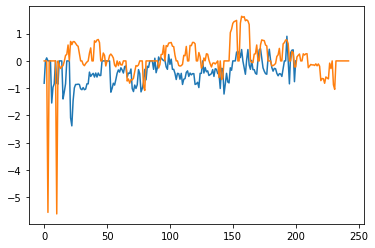

In [14]:
contours, track_ids, _ = humm_array[0]
contours = torch.Tensor(contours).unsqueeze(0)
anchor = model(contours.cuda())
anchor_norm = anchor / anchor.norm(dim=1)[:, None]
similarity = torch.mm(anchor_norm, total_embs.transpose(0,1))
#         similarity[0, j] = -100
recommends_idx = torch.topk(similarity, k=10, dim=-1)[1]
recommends = total_song_ids[recommends_idx]
ndcg = [cal_ndcg_single(recommends[i,:], track_ids) for i in range(recommends.shape[0])]
plt.plot(downsample_contour_array(ballade_contours[recommends_idx[0,0].item()]['contour'])[:,0])
plt.plot(contours[0,:,0])
# similarity[recommends_idx]

In [108]:
# play sound
humm_contour = contours[0].numpy()
humm_audio = generate_sine_wav(normalized_vec_to_orig(humm_contour))
ipd.Audio(humm_audio, rate=44100)


In [109]:
recomm_contour = downsample_contour_array(ballade_contours[recommends_idx[0,0].item()]['contour'])
recomm_audio = generate_sine_wav(normalized_vec_to_orig(recomm_contour))
ipd.Audio(recomm_audio, rate=44100)


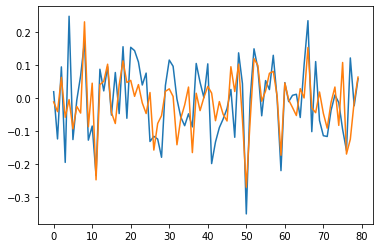

In [51]:
plt.plot(anchor.cpu().detach().numpy()[0][:80])
plt.plot(total_embs[recommends_idx[0,0].item()].cpu().detach().numpy()[:80])

In [29]:
similarity[0][recommends_idx]

tensor([[0.6820, 0.6547, 0.6526, 0.6401, 0.6372, 0.6226, 0.6123, 0.6058, 0.6049,
         0.6042]], device='cuda:0', grad_fn=<IndexBackward>)

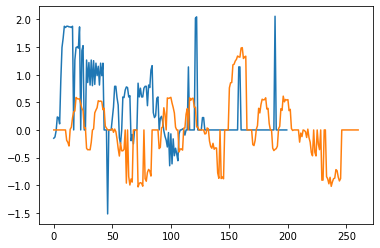

In [23]:
plt.plot(ballade_contours[recommends_idx[0,0].item()]['contour'][:,0])
plt.plot(contours[0,:,0])

In [ ]:
###### contours.shape

In [ ]:
0

In [32]:
target_id = 400
similarity = torch.mm(total_embs[target_id:target_id+1], total_embs.transpose(0,1))
# similarity[target_id-5:target_id+5]
similarity[0][target_id-5:target_id+5]

tensor([0.4567, 0.7196, 0.7374, 0.7294, 0.8986, 1.0000, 0.9044, 0.4817, 0.1355,
        0.0195], device='cuda:0')

In [40]:
dataset = humm_array

total_embs = torch.zeros([len(dataset), model.embed_size]).to('cuda')
total_song_ids = torch.zeros(len(dataset),dtype=torch.long)
current_idx = 0
model.eval()

with torch.no_grad():
    for i in range(0, len(dataset)):
        batch = torch.Tensor(dataset[i][0]).cuda().unsqueeze(0)
        song_ids = torch.Tensor([dataset[i][1]]).cuda().unsqueeze(0)
        embeddings = model(batch)
        num_samples = song_ids.shape[0]
        total_embs[i:i+num_samples,:] = embeddings / embeddings.norm(dim=1)[:,None]
        total_song_ids[i:i+num_samples] = song_ids



In [41]:
len(dataset)

500

In [16]:
# total_song_lists = list(set(total_song_ids.numpy().tolist()))
# total_song_lists = list(set(qbh_embeddings['ids']))
total_song_lists = list(set(embeddings['ids']))
total_song_lists.sort()


In [57]:
# list(zip(total_song_lists, ids))

In [17]:
ids = list(set([x[1] for x in humm_array]))
ids.sort()

dummy_pos = []
dummy_neg = []
for id in ids:
    if id in total_song_lists:
        dummy_pos.append(id)
    else:
        dummy_neg.append(id)
    
print(len(dummy_pos), len(dummy_neg), dummy_pos, dummy_neg)

99 1 [18357, 24134, 106172, 263908, 317040, 517714, 1578846, 1692881, 1836569, 1873319, 2093467, 2111256, 2114588, 2124009, 2532724, 2555445, 2799391, 3588973, 3773906, 3981176, 4143097, 4330817, 4535733, 4592195, 4674464, 4740685, 4817432, 4847750, 4892714, 5067534, 5244502, 5255931, 5341607, 5466183, 5524883, 18033477, 30344896, 30477628, 30670796, 30670806, 30691601, 30712136, 30824692, 30848289, 31009023, 31233996, 31249657, 31269126, 31296997, 31484300, 80064272, 80148698, 80169765, 80210781, 80269648, 80332393, 420497440, 420510466, 420728289, 420846670, 421021515, 421022221, 421022453, 421127232, 421311716, 421417566, 421419612, 421702106, 421881404, 422580851, 424013762, 424222484, 424643525, 427002731, 427031515, 427182485, 427198630, 427240696, 427297213, 427396913, 433467111, 433855612, 434288893, 434425125, 434441194, 434455473, 435279872, 435437035, 435439226, 435806411, 435881981, 436045232, 436055497, 436268628, 436777410, 436996887, 437200095, 437266253, 437482491] [308

In [101]:
with open('flo_metadata.dat', 'rb') as f:
    metadata = pickle.load(f)

In [126]:
# Make Kor Ballade Melody segment with hop size of 5 sec
from melody_utils import MelodyLoader
from data_utils import get_song_ids_of_selected_genre
from sampling_utils import downsample_contour
melody_loader = MelodyLoader(is_quantized=False,in_midi_pitch=True)


    # selected_genres = [29]
selected_genres = [4]
song_ids = get_song_ids_of_selected_genre(metadata, selected_genre=selected_genres)
song_ids[0]

hop_size = 50
win_size = 200

overlapped_melodies = melody_loader.get_overlapped_contours(Path('/home/svcapp/userdata/flo_data_backup/427/675/pitch_427675419.txt'))
# melody_ds = downsample_contour(melody)
# melody_form = pitch_array_to_formatted(melody_ds)
# slice_pos = list(range(0, melody_form.shape[0] - win_size, hop_size))
# slice_pos.append(melody_form.shape[0] - win_size)
# overlapped_melodies = np.asarray([melody_form[i:i+win_size]for i in slice_pos if melody_form[i:i+win_size,1] > win_size/3])

In [128]:
overlapped_melodies[0]

{'contour': array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.     

[]

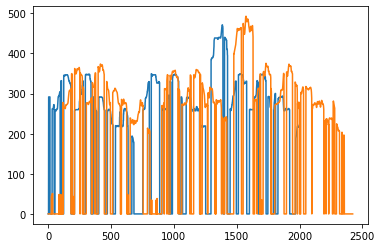

In [71]:
plt.plot(sliced_melody)
plt.plot(humm_melody)
plt.plot()

In [141]:
assertion = [1 for sample in humming_db.samples if not Path(sample['pitch_path']).exists()]

In [142]:
sum(assertion)

0

In [2]:
from simplejson import load as json_load
with open('contour_tiny.json', 'rb') as f:
    pre_loaded_data = json_load(f)

In [30]:
pre_loaded_data[0]['frame_pos']

[7303, 8160]

In [10]:
from melody_utils import MelodyLoader
melody_loader = MelodyLoader(is_quantized=False, in_midi_pitch=True)
melody = melody_loader.get_split_contour('/home/svcapp/userdata/flo_data_backup/433/840/pitch_433840535.txt')

In [44]:
melody[3]['frame_pos']

(6317, 7781)

In [49]:
compare = np.asarray([pre_loaded_data[0]['melody'][:478], melody[3]['melody'][986:]]).T

In [60]:
mean = np.mean(compare[compare[:,0]!=0,0]), np.mean(compare[compare[:,1]!=0,1])
std = np.std(compare[compare[:,0]!=0,0]), np.std(compare[compare[:,1]!=0,1])

mean, std

((0.2840073281468906, 63.2701076892324),
 (0.5531116347868245, 3.0532750612042463))

In [62]:
compare[:2]

array([[-0.67070327, 57.99993458],
       [-0.6140859 , 58.31247261]])

In [65]:
std = (compare[1, 1] - compare[0,1])/  (compare[1, 0] - compare[0,0])
mean = compare[0,1] - std * compare[0,0]
mean, std

(61.702336487738215, 5.5201786930065415)

In [147]:
def load_pitch_csv(pitch_path):
    with open(pitch_path, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    data = np.asarray(data[1:], dtype='float32')
    return data

def load_crepe_pitch(pitch_path, threshold=0.7):
    pitch_data = load_pitch_csv(pitch_path)
    pitch_data[pitch_data[:,2]<threshold, 1] = 0
    pitch_data = pitch_data[:,1]
    return pitch_data
    
pitch_path = humming_db.samples[0]['pitch_path']
pitch_data = load_crepe_pitch(pitch_path)

In [152]:
from model import CnnEncoder
import os
import torch
def load_model(hparams_path, checkpoint_path):
    with open(hparams_path, 'rb') as f:
        hparams = pickle.load(f)
    model = CnnEncoder(hparams)
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model

cnn_model = load_model('/home/svcapp/userdata/flo_model/contour_res/hparams.dat', '/home/svcapp/userdata/flo_model/contour_res/checkpoint_best.pt')

Loading checkpoint '/home/svcapp/userdata/flo_model/contour_res/checkpoint_best.pt'
Loaded checkpoint '/home/svcapp/userdata/flo_model/contour_res/checkpoint_best.pt' from iteration 1580000


In [3]:
class HummingDB:
    def __init__(self, data_path, audio_path, df_a, df_b):
        self.data_path = Path(data_path)
        self.audio_path = Path(audio_path)
        self.song_list = list(self.data_path.rglob('*.wav'))
        self.samples = [make_humming_sample_dictionary(path, df_a, df_b) for path in self.song_list]
        self.num_songs = len(self.song_list)

    def __getitem__(self, index):
        selected_sample = self.samples[index]
        song_path = selected_sample['path']
        song = AudioSegment.from_file(song_path, 'wav')._data
        decoded = np.frombuffer(song, dtype=np.int16) / 32768
        
        track_id = str(selected_sample['track_id'])
        orig_audio_path = self.audio_path / track_id[:3] / track_id[3:6] / (track_id +'.aac')
        if not orig_audio_path.exists():
            orig_audio_path = orig_audio_path.with_suffix('.m4a')
        if not orig_audio_path.exists():
            orig_audio_path = self.audio_path / 'qbh' / (track_id + '.aac')
        orig_song = AudioSegment.from_file(orig_audio_path, 'm4a').set_channels(1)._data
        orig_decoded = np.frombuffer(orig_song, dtype=np.int16) / 32768
        
        time_pos = selected_sample['time_stamp'].split('-')
        start_position = int(time_pos[0]) * 44100
        end_position = int(time_pos[1]) * 44100
                        
        return decoded, orig_decoded[start_position:end_position], selected_sample


def make_humming_sample_dictionary(path, df_a, df_b):
    sample = {}
    meta = path.stem.split('_')
    sample['path'] = str(path)

    if meta[0] == "100":
        sample['song_group'], sample['song_idx'], sample['humming_type'], sample['time_stamp'], sample['singer_group'], sample['singer_id'] = meta
        sample['singer_gender'] = sample['singer_group'][2]
        sample['singer_group'] = sample['singer_group'][1]
        row = df_a.loc[df_a['file_name'] == path.name].iloc[0]
        sample['track_id'] = row['track_id']
        sample['singer_id'] = sample['singer_id'][:-1]
        
    else:
        sample['song_group'], sample['song_idx'], sample['humming_type'], sample['time_stamp'] = meta
        
        row = df_b.loc[df_b['file_name'] == path.name].iloc[0]
        sample['track_id'] = row['track_id']
        sample['singer_gender'] = row['Identification code'][1]
        sample['singer_group'] = row['Identification code'][0]
        sample['singer_id'] = row['Identification code'][-3:]

        
    return sample
    
class HummingSample:
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        meta = self.data_path.stem.split('_')
    
humming_db = HummingDB('/home/svcapp/userdata/humming_db', '/home/svcapp/userdata/flo_data_backup/', selected_100, selected_900)
# audio = humming_db[1]
# ipd.Audio(audio, rate=44100)
print(humming_db.samples[0])


NameError: name 'selected_100' is not defined

In [167]:
audio, orig, meta = humming_db[200]
print(meta)
ipd.Audio(audio, rate=44100)

{'path': '/home/svcapp/userdata/humming_db/100/50~74/02_N/100_53_D_82-99_(NM_GHW).wav', 'song_group': '100', 'song_idx': '53', 'humming_type': 'D', 'time_stamp': '82-99', 'singer_group': 'N', 'singer_id': 'GHW', 'singer_gender': 'M', 'track_id': 420497440}


In [168]:
ipd.Audio(orig, rate=44100)

In [170]:
len(set([x['track_id'] for x in humming_db.samples]))

999

In [134]:
singer_ids = set([x['singer_group'] for x in humming_db.samples])
print(singer_ids, len(singer_ids))
for ids in singer_ids:
    print(sum([1 for x in humming_db.samples if x['singer_group'] == ids]))

{'P', 'N'} 2
560
840


In [31]:
xls_file = pd.ExcelFile("/home/svcapp/userdata/humming_db/Spec.xlsx")
sheets = pd.read_excel(xls_file, sheet_name=None, header=1)
exp_id = list(sheets.keys())
selected_100 = [sheets[x] for x in exp_id[:4]]
selected_100 = pd.concat(selected_100, ignore_index=True)
selected_900 = sheets[exp_id[4]]

with open("flo_metadata.dat", "rb") as f:
    data_dict = pickle.load(f)
# for data in data_dict:
#     data['track_name'] = str(data['track_name'])
#     while data['track_name'][-1] == ' ':
#         data['track_name'] = data['track_name'][:-1]



def get_track_id(song_name, artist_name, data_dict):
    for song in data_dict:
        if song_name == str(song['track_name']) and str(artist_name) in str(song['artist_name_basket'][0]):
            return song['track_id']
    print(f"{song_name} / {artist_name}")
    
# track_ids = [get_track_id(selected_900['track_name'][x], selected_900['artist_name'][x], data_dict) for x in range(900) ]
track_ids100 =  [get_track_id(selected_100['track_name'][x], selected_100['artist_name'][x], meta_100) for x in range(500) ]

selected_100['track_id'] = track_ids100
selected_900['track_id'] = track_ids

In [32]:
meta_100 = pd.read_csv("flo_test_list.csv")
meta_100 = meta_100.rename(columns={'곡명': 'track_name', '아티스트명': 'artist_name_basket', 'track id ': 'track_id'})
meta_100['artist_name_basket'] = [[x] for x in meta_100['artist_name_basket'] ]
meta_100 = meta_100.to_dict('records')

with open('meta_100.dat', 'wb') as f:
    pickle.dump(meta_100, f)

In [123]:
selected_900['Identification code']

0      NM_PJW
1      NM_PJW
2      NM_PJW
3      NM_PJW
4      NM_PJW
        ...  
895    PM_YYS
896    PM_YYS
897    PM_YYS
898    PM_YYS
899    PM_YYS
Name: Identification code, Length: 900, dtype: object

In [72]:

# from collections import Counter
# test = Counter(track_ids)
# test.most_common(10)

In [104]:
selected_900

Column1            album_name     artist_name  \
0          0                    항해    AKMU (악동뮤지션)   
1          1             Love poem        아이유 (IU)   
2          2     늦은 밤 너의 집 앞 골목길에서              노을   
3          3                조금 취했어             임재현   
4          4                  새 사랑             송하예   
..       ...                   ...             ...   
895      895             Honeymoon     Beach Bunny   
896      896  Sunsets & Full Moons      The Script   
897      897           Skiptracing  Mild High Club   
898      898              Dreaming       Green Day   
899      899         La Trimouille   Peter & Kerry   

                     track_name Identification code            file_name  \
0     어떻게 이별까지 사랑하겠어, 널 사랑하는 거지              NM_PJW    900_0_C_19-40.wav   
1                     Love poem              NM_PJW    900_1_B_15-43.wav   
2             늦은 밤 너의 집 앞 골목길에서              NM_PJW    900_2_C_43-66.wav   
3           조금 취했어 (Prod. 2soo)              NM_PJW    900_3_C_42-68.wav   
4                          새 사랑              NM_PJW    900_4_D_15-41.wav   
..                          ...                 ...                  ...   
895                    Promises              PM_YYS  900_895_B_40-65.wav   
896  If You Don't Love Yourself              PM_YYS  900_896_D_24-43.wav   
897                    Head Out              PM_YYS  900_897_B_25-45.wav   
898                    Dreaming              PM_YYS  900_898_B_48-67.wav   
899                I Don't Know              PM_YYS  900_899_A_50-71.wav   

    Sampling rate Channel     Bits   Duration  Number of Samples  \
0        48000 Hz    mono  16 bits  00:24.256            1164288   
1        48000 Hz    mono  16 bits  00:32.917            1580031   
2        48000 Hz    mono  16 bits  00:26.112            1253376   
3        48000 Hz    mono  16 bits  00:28.693            1377279   
4        48000 Hz    mono  16 bits  00:30.059            1442816   
..            ...     ...      ...        ...                ...   
895      48000 Hz    mono  16 bits  00:29.952            1437696   
896      48000 Hz    mono  16 bits  00:21.504            1032192   
897      48000 Hz    mono  16 bits  00:22.123            1061888   
898      48000 Hz    mono  16 bits  00:19.819             951296   
899      48000 Hz    mono  16 bits  00:23.488            1127424   

    Size on Memory     max_dB  track_ids  
0       2274.13 kB   -5.23 dB  427675419  
1       3086.09 kB   -4.68 dB  433090157  
2       2448.12 kB   -3.58 dB  433359099  
3       2690.10 kB   -3.50 dB  427664823  
4       2818.09 kB   -8.34 dB  431421835  
..             ...        ...        ...  
895     2808.10 kB   -7.55 dB  434093591  
896     2016.10 kB   -8.82 dB  431984079  
897     2074.10 kB  -12.98 dB   30367944  
898     1858.10 kB   -6.71 dB  435617063  
899     2202.10 kB  -11.44 dB    2725337  

[900 rows x 14 columns]

In [ ]:
class DataMonitor:
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        if 'qbh' in data_path:
            self.song_list = list(self.data_path.rglob('*.aac'))
            self.song_list = [x.stem for x in self.song_list]
        else:
            self.song_list = np.load('song_indices_in_flo.npy')
#         self.contour_list = list(self.data_path.rglob('*.txt'))
        self.sr = 44100
        
    def get_contour(self,index):
        song_idx = self.song_list[index]
        pitch_path = self.song_idx_to_path(song_idx).parent / 'pitch_{}.txt'.format(song_idx)
        return load_melody(pitch_path)

    def get_audio(self, song_id, id1, id2):
        song_path = self.song_idx_to_path(song_id)
        audio = self.load_audio(song_path)
        audio = audio[id1:id2]
        return audio

    def load_audio(self, track_path):
        song = AudioSegment.from_file(track_path, 'm4a').set_frame_rate(self.sr).set_channels(1)._data
        decoded = np.frombuffer(song, dtype=np.int16) / 32768
        return decoded

    def song_idx_to_path(self, idx):
        idx = str(idx)
        if 'qbh' in str(self.data_path):
            path = self.data_path / (idx +'.aac')
        else:
            path = self.data_path / idx[:3] / idx[3:6] / (idx +'.aac')
        if not path.exists():
            path = path.with_suffix('.m4a')
        return path
    
    def sample_random_melody(self):
        while True:
            rand_index = random.randint(0, len(self)-1)
            contour = self.get_contour(rand_index)
            q_contour = quantizing_hz(contour)
            c_contour = clearing_note(q_contour)
            melody_indices = self.find_melody_segment(c_contour)
            if len(melody_indices) > 0:
                rand_mel_idx = random.randint(0, len(melody_indices)-1)
                a,b = melody_indices[rand_mel_idx]
                return contour[a:b]
    
    def plot_and_play(self, idx):
        contour = self.get_contour(idx)
        q_contour = quantizing_hz(contour)
        c_contour = clearing_note(q_contour)
        e_contour = elongate_note(c_contour)

        melody_indices = self.find_melody_segment(c_contour)
        if len(melody_indices) > 0:
            a,b = melody_indices[random.randint(0, len(melody_indices)-1)]
            plt.plot(contour[a:b])
#             plt.plot(q_contour[a:b])
            plt.plot(e_contour[a:b])
#             plt.plot(e_contour[a:b])
#             print(q_contour[a:b])
            audio = self.get_audio(self.song_list[idx], a*self.sr//100, b*self.sr//100)
#             audio = self.generate_sine_wav(e_contour[a:b], audio)
            audio = self.generate_sine_wav(contour[a:b], audio)

            return audio 
    
    def find_melody_segment(self, contour, threshold=50):
        return find_melody_seg_fast(contour, zero_threshold=50, max_length=2000, min_length=500)
    
    def get_segmented_contours(self, song_idx):
        pitch_path = self.song_idx_to_path(song_idx).parent / 'pitch_{}.txt'.format(song_idx)
        contour = load_melody(pitch_path)
        return [{'melody':contour[a:b], 'frame_pos':(a,b)} for (a,b) in self.find_melody_segment(contour)]
    
    def generate_sine_wav(self, melody, audio, frame_rate=100):
        melody_resampled = np.repeat(melody, self.sr//frame_rate)
        phi = np.zeros_like(melody_resampled)
        phi[1:] = np.cumsum(2* np.pi * melody_resampled[:-1] / self.sr, axis=0)
        sin_wav = 0.9 * np.sin(phi)
        sin_wav = sin_wav[:audio.shape[0]]
        return sin_wav+(audio*0.3)
    
    def __len__(self):
        return len(self.song_list)
    

def quantizing_hz(contour):
    output = []
    for pitch in contour:
        if pitch > 0:
            q_pitch = 440 * (2 ** ((round(log2(pitch/440) * 12))/12))
        else:
            q_pitch = 0
        output.append(q_pitch)
    return output

def elongate_note(q_contour, patience=10):
    output = []
    prev_pitch = 0
    non_pitch_count = 0
    for pitch in q_contour:
        if pitch > 0:
            output.append(pitch)
            prev_pitch = pitch
            non_pitch_count = 0
        else:
            non_pitch_count += 1
            if non_pitch_count > patience:
                prev_pitch = 0
                non_pitch_count = 0
            output.append(prev_pitch)
    return output

def clearing_note(q_contour, min_pitch_len=5):
    prev_pitch = 0
    prev_pitch_start = 0
    output = [x for x in q_contour]
    for i in range(len(q_contour)):
        pitch = q_contour[i]
        if pitch != prev_pitch:
            prev_pitch_duration = i - prev_pitch_start
            if prev_pitch_duration < min_pitch_len:
                output[prev_pitch_start:i] = [0] * prev_pitch_duration
            prev_pitch = pitch
            prev_pitch_start = i
    return output

def load_melody(path):
    with open(path, "r") as f:
        lines = f.readlines()
    return [float(x.split(' ')[1][:-2]) for x in lines]

def find_melody_seg_fast(contour,zero_threshold, max_length, min_length):
    zeros_slice = get_zero_slice_from_contour(contour, threshold=zero_threshold)
    voice = zero_slice_to_segment(zeros_slice)
    if voice != []:
        expand_voice(voice, max_length=max_length)
    voice = [(int(x[0]), int(x[1])) for x in voice if x[1]-x[0]>min_length]
    return voice

def get_zero_slice_from_contour(contour, threshold=50):
    contour_array = np.asarray(contour)
    is_zero_position = np.where(contour_array == 0)[0]
    diff_by_position = np.diff(is_zero_position)
    slice_pos = np.where(diff_by_position>1)[0]
    voice_frame = np.stack([is_zero_position[slice_pos]+1, is_zero_position[slice_pos] + diff_by_position[slice_pos]], axis=-1)
    if voice_frame.shape[0] == 0:
        zeros_slice = []
    else:
        zeros_slice = [ [0, voice_frame[0,0]] ] + [ [voice_frame[i-1,1], voice_frame[i,0]] for i in range(1, voice_frame.shape[0])]
        zeros_slice = [x for x in zeros_slice if x[1]-x[0] > threshold]
    return zeros_slice

def zero_slice_to_segment(zeros_slice, min_voice_seg=10):
    return [ (zeros_slice[i][1], zeros_slice[i+1][0]) for i in range(len(zeros_slice)-1) if zeros_slice[i+1][0] - zeros_slice[i][1]  >= min_voice_seg]

def expand_voice(voice_slice, max_length=2000):
    def merged_length(alist, idx):
        return alist[idx][0] + alist[idx][1] + alist[idx+1][0]
    len_and_distance = get_length_and_distance_of_melody(voice_slice)
#     valid_distances = [len_and_distance[i][1] for i in range(len(len_and_distance)-1) if len_and_distance[i][0] +len_and_distance[i+1][0]<max_length]
    valid_distances = [ len_and_distance[i][1] for i in range(len(len_and_distance)-1) if merged_length(len_and_distance, i) <max_length]
    while valid_distances:
        min_distance = min(valid_distances)
        min_index = [i for i in range(len(len_and_distance)-1) if len_and_distance[i][1] ==min_distance and  merged_length(len_and_distance, i) <max_length]
        for index in reversed(min_index):
            merge_voice_slice(voice_slice, index)
        if voice_slice == []:
            valid_distances = []
        else:
            len_and_distance = get_length_and_distance_of_melody(voice_slice)
            valid_distances = [ len_and_distance[i][1] for i in range(len(len_and_distance)-1) if merged_length(len_and_distance, i) <max_length]
    return voice_slice

def merge_voice_slice(voice_slice, index):
    first = voice_slice.pop(index)
    second = voice_slice.pop(index)
    new = (first[0], second[1])
    voice_slice.insert(index, new)

def get_length_and_distance_of_melody(voice_slice):
    return [ (voice_slice[i][1]-voice_slice[i][0], voice_slice[i+1][0]-voice_slice[i][1]) for i in range(len(voice_slice)-1)] + [(voice_slice[-1][1]-voice_slice[-1][0], 10000 )]